# DataGlue v040
Moved to Jupyter Notebook 5/11/20

5/17 - Running up to SelectKBest feature selection.
       Add feature selector code from other notebook.

Done 1. Apply Trade Profile to xtns.
Done 2. Create stock features - SMAs, velocities, oscillators - MACD, RSI, MFI, etc, Days to ER
Done 3. Completed RSI, MFI, and MACD 5/17/20
Done 4. Merge / join with Option trade records
Done 5. Define label. 
Done 6. Scaling. Check for outliers. Run standardScaler.

5. Feature Selection / Reduction - Univariate SelectKBest, Correlation Heat Map, RFE, PCA. 
     Choose final features for first run.
6. Test many Learners against single trades. Pick best few.
7. Measure Learners against portfolio metrics. 
8. Find trade profit % that optimizes portfolio metrics.
9. Rerun Learners with that profit% as label.

10. Define process to use and test BTC.


In [1]:
# IMPORT LIBRARIES

import sys
import math
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# BDay is business day, not birthday...
from pandas.tseries.offsets import BDay
from pandas.tseries.offsets import CustomBusinessDay as CBDay
from scipy.stats import linregress

# Libraries for Visualizers
import matplotlib
import matplotlib.pyplot as plt

# ML Libraries from SKLearn.
import random
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
from sklearn import svm
from sklearn import metrics
from sklearn.decomposition  import PCA
from sklearn.preprocessing  import StandardScaler
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble       import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes    import GaussianNB
from sklearn.datasets       import make_classification
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif


# FLOW CONTROL AND CONFIGURATION - Flow Control maybe not needed in Notebook?

TEST_TYPES        = ('golden test', 'code locator', 'code run times', 'none')  #These drive the test configuration for the run.
test_config       = ('none')

FEATURE_TYPES     = ('price calc', 'velocity calc')  #price calc automatically does ER calc
feature_select    = ('price calc', 'velocity calc')

correlate = False  # Run corrrelation section
visualize = False   # Run charts for each feature comparing data grouped by label.

# CONSTANTS

NYSE_HOLIDAYS = ('2017-01-02 00:00:00', '2017-01-16 00:00:00', '2017-02-20 00:00:00', '2017-04-14 00:00:00', \
                 '2017-05-29 00:00:00', '2017-07-04 00:00:00', '2017-09-04 00:00:00', '2017-11-23 00:00:00', '2017-12-25 00:00:00', \
                 '2018-01-01 00:00:00', '2018-01-15 00:00:00', '2018-02-19 00:00:00', '2018-03-30 00:00:00', \
                 '2018-05-28 00:00:00', '2018-07-04 00:00:00', '2018-09-03 00:00:00', '2018-11-22 00:00:00', '2018-12-25')
# add NYSE holidays for 2019, 2020 to complete the set.


BUCKET_COUNT      = 25  #used for bucket normalizers

LOCATIONS = ('initialize', 'price feature calcs', 'join', 'delete xtn cols', 'feature buckets')
             #LOCATIONS is the set values for code_location, used by fct TestProbe.

code_speed_columns = ('Clock Time', 'Location', 'Exec Time')

XTNS_COLS = ('stock_price_at_STO_offer', 'STO_ask_fee', 'STO_ask_fee_type',
          'STO_offer_datetime', 'STO_strike', 'STO_expiry_datetime',
          'STO_days_long', 'STO_offer_ARR', 'STO_offer_TQI', 'STO_offer_strike_delta',
          'STO_xtn_state', 'STO_contracts', 'option_type', 'stock_price_BTC_offer',
          'BTC_bid_fee', 'BTC_bid_fee_type', 'BTC_offer_datetime', 'BTC_contracts',
          'stock_price_at_open', 'STO_open_fee', 'STO_open_commsn', 'STO_open_proceeds',
          'STO_open_datetime', 'STO_open_ARR', 'STO_open_TQI', 'STO_open_strike_delta',
          'stock_price_at_close', 'STO_close_strike_delta', 'BTC_close_commsn', 'BTC_close_proceeds',
          'STO_close_datetime', 'STO_close_ARR', 'STO_close_TQI', 'Called_close_fee',
          'Called_close_commsn', 'Called_close_proceeds', 'STO_xtn_net_proceeds'
          )

# Other xtn_cols to consider as features:  'STO_Offer_datetime', 'STO_open_strike_delta', 'STO_offer_strike_delta'     

FEATURES_IN_XTNS_COLS = ('stock_price_at_STO_offer', 'STO_ask_fee', 'STO_strike', \
                         'STO_days_long', 'STO_offer_ARR', 'STO_offer_TQI', 'stock_price_at_open', 'Closed_xtn_Profit$', \
                         'Closed_xtn_Profit%','STO_open_strike_delta%', 'STO_offer_strike_delta%', 'STO_ask_fee%')

MIN_XTN_FEATURES = ('stock_price_at_STO_offer', 'STO_strike', \
                    'STO_days_long', 'STO_offer_ARR', 'stock_price_at_open', 'Closed_xtn_Profit%', 'Closed_xtn_Profit$', \
                    'STO_open_strike_delta%', 'STO_offer_strike_delta%', 'STO_ask_fee%')  #10 features, plus the label (Closed Price Profit%. 

MIN_PRICE_FEATURES = ('45 day SMA', '30 day SMA', '15 day SMA', '10 day SMA', 'Yearly Min', 'Yearly Max', \
                      '5 days old', '4 days old', '3 days old', '2 days old', '1 days old', 'ER - Expiry', \
                      'RSI', 'MFI', 'MACD' 
                     ) #12 features for price. 3 features for signals

MIN_VELOCITY_FEATURES = ('45 day vel', '30 day vel', '15 day vel', '10 day vel', \
                     '5 day vel', '2 day vel')   # 6 features


# VARIABLES

xtns                    = pd.DataFrame()
features                = pd.DataFrame()
stock_featrures         = pd.DataFrame()
stock_velocity_features = pd.DataFrame()
stock_OHLC_data         = pd.DataFrame()
corr_table              = pd.DataFrame()
learner_stats           = pd.DataFrame()
y_preds                 = pd.DataFrame()


## Functions

- GoldenTest - runs golden test vectors.
- PriceFeatureCalc - inputs  = XOM OHLC.csv
                   - outputs = SMA features, Yearly High/Low features, Days to ER
- VelocityFeatureCalc - calculates velocity features from stock price OHLC dataframe
- RunLearners - runs a set of Learners with given train and test data.
              - collects basic stats in a dataframe.
- Chart_Features_2Plot - charts each feature with winners and losers in different colors. v1.0, not used.
- Chart_Features_Label_Separation - v2.0 of the fct above. This one actually works.


## Functions


In [2]:
#***********************
def GoldenTest(code_loc):
#***********************
   global test_config
   global speed_row
   global code_speed
   global code_speed_row
   global code_speed_columns

   if 'golden test' in test_config:   # set up golden test configuration
      # print('in TestProbe, code_loc = ', code_loc) #for debug
      if code_loc == 'initialize':  #Set all Option strategy parameters to the kgolden test configuraiton
         print(' *** in TestProbe *** golden test is in test_config.')

         trade_days1   = pd.read_csv('DataGlue_GoldenTradeDays1.csv', index_col = False)
         trade_days2   = pd.read_csv('DataGlue_GoldenTradeDays2.csv', index_col = False)
         feature_days1 = pd.read_csv('DataGlue_GoldenFeatureDays1.csv', index_col = False)
         feature_days2 = pd.read_csv('DataGlue_GoldenFeatureDays2.csv', index_col = False)


   if 'code run times' in test_config: #Write the df to DataGlue_code_speed
       print('here in TestProbe, module -code run times- we got nuttin.')
       #probably no need for code_speed in this module
       #code_speed.loc[speed_row, 'Clock Time'] = datetime.now()
       #code_speed.loc[speed_row, 'Location']   = code_loc
       #speed_row += 1
      
   if 'code locator' in test_config:
      print('     ------')
      print('     ', code_loc)
      print('     ------')

In [3]:
#*******
def PriceFeatureCalc():
    #
    # Goal - Prepare stock price data features for gluing to the option xtn records
    #        Check time of ER report. If after close, then ER day is OK.
    #        If ER report before stock market open, then must use ER day - 1 for the join fct.
    #        1. Download stock OHLC data from Yahoo or other. Remember to get early data for max calc offset (255 days for annual hi/low)
    #        2. Choose data set to generate -
    #           To start, try SMAs for 45, 30, 15, and 10 days
    #           Also 12 month hi/lo. Need data for 12 months (255 days) prior to start day.
    #           Also Closing price for last 5 days
    #           days_to_ER
    #        3. Calculate all elements of the data set using downloaded data file.

    # Price Feature Config Parameters
    global stock_OHLC_data
    global stock_features

  
    print('+++ Here in PriceFeatureCalc')
    SMA_periods = [45, 30, 15, 10]
    days_per_year = 253
    previous_days = 5
    
    stock_OHLC_data    = pd.DataFrame()
    ER_Dates           = pd.DataFrame()

    input_file_name    = 'XOMOHLC 2016-2018.csv'
    output_file_name   = 'XOM_feature_set_2017.csv'
    ER_input_file_name = 'XOM_ER_Dates.csv'

    #+++++
    #Read input files
    stock_OHLC_data  = pd.read_csv(input_file_name, index_col = False)
    ER_Dates         = pd.read_csv(ER_input_file_name, index_col = False)
    stock_features   = pd.read_csv(input_file_name, index_col = False)

    #+++++
    # Create price features - SMAs, hi/lows, and trailiing daily prices.
    print('+++++ Calculating price features.')
    
    for days in SMA_periods:      #this loop so easy!
       SMA_col_label = str(days) + ' day SMA'
       stock_features[SMA_col_label] = stock_features['Close'].rolling(window = days).mean()

    stock_features['Yearly Min'] = stock_features['Close'].rolling(days_per_year).min()
    stock_features['Yearly Max'] = stock_features['Close'].rolling(days_per_year).max()

    for prev_day in range(1,(previous_days+1)):
       stock_features[str(prev_day) + ' days old'] = stock_features['Close'].shift(prev_day)

    #+++++
    # Create days to ER
    # Convert time strings to datetime.date objects
    print('+++++ Here in ER calc')
    stock_features['Date'] = pd.to_datetime(stock_features['Date'], format = '%Y-%m-%d')

#    ER_Dates['ER Date'] = pd.to_datetime(ER_Dates['ER Date'], format = '%Y-%m-%d')
#copy start for Jupyter
    stock_features['Days to ER']  = -999 #initialize this col with invalid value. If a -1 shows up, something broke.

    for j in range(stock_features.shape[0]):
        stock_features.loc[j, 'Days to ER'] = (pd.to_datetime(ER_Dates.loc[0, 'ER Date']) - 
                                               pd.to_datetime(stock_features.loc[j,'Date'])).days
        #print('days = ', stock_features.loc[j, 'Days to ER'])
        if stock_features.loc[j, 'Days to ER'] <= 0:   #If passed this ER Date, then delete it and move to the next ER Date.
                                                             # This loop cannot skip two ER Dates in a row. Must be at least one
                                                             # features date between every ER Date. Pretty reasonable.
                ER_Dates.drop(0, inplace = True)             # This destroys ER_Dates. DO NOT write it back to disk or use it again.
                ER_Dates.reset_index(inplace = True, drop = True)
                stock_features.loc[j, 'Days to ER'] = (pd.to_datetime(ER_Dates.loc[0, 'ER Date']) - \
                                                             pd.to_datetime(stock_features.loc[j,'Date'])).days

    stock_features.to_csv('XOM_price_features.csv', index = False)
    
    #------
    # Vector version of Days_to_ER. Get this working to use in notebook.
    #-------
##      stock_features['Days to ER'] = -999
##      ER_Dates['ER Date']         = pd.to_datetime(ER_Dates['ER Date'])
##      stock_features['Date'] = pd.to_datetime(stock_features['Date'])
##                                           
##      for ER_index in range(1, ER_Dates.shape[0]+1):
##          print('type of last_ER_date = ', type(last_ER_Date))
##          last_ER_Date = pd.to_datetime(ER_Dates.loc[ER_index-1, 'ER Date'])
##          next_ER_Date = pd.to_datetime(ER_Dates.loc[ER_index,   'ER Date'])
##
##          print('Date col type = ', stock_features['Date'])
##          print('Date element type = ', stock_features.loc[1,'Date'])
##          stock_features['Date_outside_ER_range'] = (pd.to_datetime(stock_features['Date']) <=  last_ER_Date | \
##                                   pd.to_datetime(stock_features['Date']) > next_ER_Date)
##          print('Date_outside_ER_range = ',type(stock_features['Date_outside_ER_range']))
##                
##          stock_features['Days to ER'] = stock_features['Days to ER'].where(stock_features['Date_outside_ER_range'], \
##                                               other = (next_ER_Date - pd.to_datetime(stock_features['Date'])).days, \
##                                               inplace = True)
##          print()
##          print('Vector solution')
##          
##          print(stock_features['Days to ER'].head(10))
##          print(stock_features['Days to ER'].tail(10))


In [4]:
#*******
def OscillatorFeatureCalc():
    #
    # Calculate several common oscillators
    #     RSI - Relative Strength - Just a SMA of gains vs. losses over 14 periods. NOT EMA, as some suggest!
    #     MFI - volume weighted RSI - Volume weighted RSI. Also based on a 14 day SMA.
    #     MACD - 9 period EMA of (12 period EMA - 26 period EMA).
    #     Consider Bollinger Bands, Put/Cll Raito, and Open Interest.
    
    global stock_OHLC_data
    global stock_features
    
    #++++++++++
    # RSI Calculation
    RSI_period = 14

    signals = pd.DataFrame()
    
    signals['Adj Close'] = stock_OHLC_data['Adj Close']
    signals['close delta'] = signals['Adj Close'].diff().dropna()
    
    signals['Upday'] = 0.0
    signals['Upday'].where(signals['close delta']<=0.0,  other = signals['close delta'], inplace = True)
    signals['Upsum'] = signals['Upday'].rolling(window = RSI_period).mean()

    signals['Dnday'] = 0.0
    signals['Dnday'].where(signals['close delta']>=0.0, other = -signals['close delta'], inplace = True)
    signals['Dnsum'] = signals['Dnday'].rolling(window = RSI_period).mean()
    
    signals['RSI'] = 100 - (100 / (1 + (signals['Upsum'] / signals['Dnsum'])))
    
    #++++++++++
    # MFI Calculation
    
    MFI_period = 14
    signals['typical_price'] = (stock_OHLC_data['High'] +  stock_OHLC_data['Low'] + stock_OHLC_data['Adj Close']) / 3
    signals['raw_money'] = signals['typical_price'] * stock_OHLC_data['Volume']
    signals['price_delta'] = signals['typical_price'].diff().dropna()
    
    signals['UpMoney'] = 0.0
    signals['UpMoney'].where(signals['price_delta']<0.0,  other = signals['raw_money'], inplace = True)
    signals['UpMoneySum'] = signals['UpMoney'].rolling(window = MFI_period).mean()
        
    signals['DnMoney'] = 0.0
    signals['DnMoney'].where(signals['price_delta']>0.0, other = signals['raw_money'], inplace = True)
    signals['DnMoneySum'] = signals['DnMoney'].rolling(window = MFI_period).mean()

    signals['MFI'] = 100.0 - (100.0 / (1 + (signals['UpMoneySum'] / signals['DnMoneySum'])))
    
    #++++++++++
    # MACD Calculation - You can calculate EMAs from SMAs, or just use the pandas df.ewm function
    
    signals['12 day EMA'] = stock_OHLC_data['Adj Close'].ewm(span = 12, adjust = False).mean()
    signals['26 day EMA'] = stock_OHLC_data['Adj Close'].ewm(span = 26, adjust = False).mean()
    signals['MACD'] = (signals['12 day EMA'] - signals['26 day EMA']).ewm(span = 9, adjust = False).mean()
    
    signal_cols = ['RSI', 'MFI', 'MACD']
    for i in signal_cols:
        stock_features[i] = signals[i]  #Add oscillator features to stock_features


In [5]:
#*******
def VelocityFeatureCalc():
    #
    # Calculate stock price velocities for various intervals.
    # Use lineregress() to get the slope for each time interval.
    
    global stock_OHLC_data
    global stock_features
    
    v_periods = (45, 30, 15, 10, 5, 2)
    max_row = stock_OHLC_data.shape[0]

    stock_price_list = stock_OHLC_data['Close'].to_list()
    max_row = len(stock_price_list)

    for period in v_periods:
             x_values = list(range(period))
             #print('x_values = ', x_values)
             velocity = []             #initialize velocity list. This will be added to stock_velocity df.
             for i in range(period-1): # initialize first values as 'NaN'
                    velocity.append('NaN')
             for window_end in range(period - 1, max_row):
                    y_values = stock_price_list[window_end-(period-1):window_end+1]               # get a slice of prices, width of window.
                    slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)  # get the slope (velocity
                    velocity.append(slope)
             col_name = str(period) + ' day vel'
             stock_features[col_name] = velocity

#    stock_velocity_features['Date'] = pd.to_datetime(stock_velocity_features['Date'], format = '%Y-%m-%d')
    
    


In [6]:
#*******
def RunLearners(Xr_train, Xr_test, yr_train, yr_test, all_run_stats, run_ID):
   #
   # Run several learners with same data sets.
   # Record the performance stats in df learner_stats
   # Can add variations of each learner - change depth for RandForest, neighbors for KNN, alpha for MLP etc.
   #
   # Create new df learner_this_run for each time fct runs. When complete, append stats_this_run to learner_stats

   this_run_stats = pd.DataFrame()
   y_pred_cols    = pd.DataFrame()
   
   learners = {'RandomForest_d7' : RandomForestClassifier(max_depth=7,    random_state=97),
               # 'RandomForest_d9' : RandomForestClassifier(max_depth=9,  random_state=97),
               # 'RandomForest_d11': RandomForestClassifier(max_depth=11, random_state=97),
               # 'RandomForest_d13': RandomForestClassifier(max_depth=13, random_state=97),
               'RandomForest_d15': RandomForestClassifier(max_depth=15,   random_state=97),
               # 'RandomForest_d17': RandomForestClassifier(max_depth=17, random_state=97),
               'RandomForest_d19': RandomForestClassifier(max_depth=19,   random_state=97),
               'KNNeighbors_2'   : KNeighborsClassifier(n_neighbors=2),
               # 'KNNeighbors_3'   : KNeighborsClassifier(n_neighbors=3),
               # 'KNNeighbors_4'   : KNeighborsClassifier(n_neighbors=4),
               'AdaBoost'        : AdaBoostClassifier(n_estimators = 100, random_state = 97),
               'GaussianNB'      : GaussianNB(),
               # 'SVC poly'        : svm.SVC(kernel = 'poly'),
               'SVC linear'      : svm.SVC(kernel = 'linear')
               }
    
   learner_types = learners.keys()
   for learner in learner_types:
      clf = learners[learner]
      clf.fit(Xr_train, yr_train)

      yr_pred = clf.predict(X_test)
      y_pred_cols[learner] = yr_pred

      print()
      print(learner, ' accuracy      = ', metrics.accuracy_score(yr_test, yr_pred))
      print(learner, ' avg. precison = ', metrics.average_precision_score(yr_test, yr_pred))

      this_run_stats.loc[learner, 'Accuracy'] = metrics.accuracy_score(yr_test, yr_pred)
      this_run_stats.loc[learner, 'Precision'] = metrics.average_precision_score(yr_test, yr_pred)

   this_run_stats['run_ID'] = run_ID
   all_run_stats = all_run_stats.append(this_run_stats)
   print('all_run_stats = ')
   print(all_run_stats)      
   return all_run_stats, y_pred_cols


In [7]:
#*******
def Chart_Features_2Plot(features, base_curve):
   # This fct charts each features col. against base_curve.
   # 1. Normalize all data in range 0-to-1, or -1-to-1
   #      or just use left and right axes. Right axis for price, left axis for feature.
   # 2. Plot 3 cols of charts, as many as needed.
   # 3. Red is price, green is the feature.
   print('show me some feature pix')
   fig,axes =plt.subplots(10,3, figsize=(12, 25)) # 3 columns each containing 10 figures, total 30 features
   winners = opt_sample[opt_sample['label']==1]    # define winners
   losers  = opt_sample[opt_sample['label']==0]    # define losers
   #print('winners = ')
   #print(winners)

   winners = winners.to_numpy()
   losers  = losers.to_numpy()
   opt_np  = opt_sample.to_numpy()

   ax=axes.ravel()# flat axes with numpy ravel

   for i in range(len(opt_sample.columns.values)):
     _,bins=np.histogram(opt_np[:,i],bins=40)
     
     ax[i].hist(losers[:,i],bins=bins,color='r',alpha=.5)# red color for malignant class
     ax[i].hist(winners[:,i],bins=bins,color='g',alpha=0.3)# alpha is for transparency in the overlapped region
     print('assigned histogram, now try labels.')
     ax[i].set_title(opt_sample.columns.values[i],fontsize=9)
     ax[i].axes.get_xaxis().set_visible(False) # the x-axis co-ordinates are not so useful, as we just want to look how well separated the histograms are
     ax[i].set_yticks(())
   ax[0].legend(['losers','winners'],loc='best',fontsize=8)
   plt.tight_layout()# let's make good plots
   plt.show()

def Chart_Feature_Label_Separation(opt_sample):
   print('show some pictures. opt_sample shape')
   print(opt_sample.shape)
   fig,axes =plt.subplots(10,3, figsize=(12, 20)) # 3 columns each containing 9 figures, total 27 features
   winners = opt_sample[opt_sample['label']==1]    # define winners
   losers  = opt_sample[opt_sample['label']==0]    # define losers
   #print('winners = ')
   #print(winners)

   winners = winners.to_numpy()
   losers  = losers.to_numpy()
   opt_np = opt_sample.to_numpy()

   ax=axes.ravel()# flat axes with numpy ravel

   print('setting up bins.') 
   for i in range(len(opt_sample.columns.values)):
     _,bins=np.histogram(opt_np[:,i],bins=40)
     
     ax[i].hist(losers[:,i],bins=bins,color='r',alpha=.5)# red color for malignant class
     ax[i].hist(winners[:,i],bins=bins,color='g',alpha=0.3)# alpha is           for transparency in the overlapped region
     ax[i].set_title(opt_sample.columns.values[i],fontsize=9)
     ax[i].axes.get_xaxis().set_visible(False) # the x-axis co-ordinates are not so useful, as we just want to look how well separated the histograms are
     ax[i].set_yticks(())
   ax[0].legend(['losers','winners'],loc='best',fontsize=8)
   plt.tight_layout()# let's make good plots
   plt.show()


In [8]:
# *****************
#
# MAIN PROGRAM STARTS HERE
#
# *****************

#******************
# XTNS df - Get and prep for joining.
# 1. Apply Trade Profile
# 1. Calculate any new features in xtns.
# 2. Drop non-features from xtns, but keep the date cols for joining.
# *****************

xtns = pd.read_csv('closed_xtns_.csv', index_col = False)
# Apply Trade Profile Rules.
MIN_FEE = 0.50 # sets minimum fee $, not minimum fee %

profile_mask = xtns['STO_ask_fee'] > MIN_FEE
xtns = xtns[profile_mask].copy()

xtns.to_csv('xtns_.csv', index_label = False)
           
print('xtns after Trade Profile')
print(xtns.shape)

# Calculate all additional feature cols from xtns
xtns['STO_ask_fee%']            = xtns['STO_ask_fee'] / xtns['stock_price_at_STO_offer']
xtns['STO_offer_strike_delta%'] = (xtns['STO_strike'] - xtns['stock_price_at_STO_offer']) / xtns['stock_price_at_STO_offer']
#xtns['STO_open_strike_delta%']  = (xtns['STO_strike'] - xtns['stock_price_at_open']) / xtns['stock_price_at_open']

#These two are the goodness criteria. Add ClosedBTC when that is included in a run.
xtns['STO_open_proceeds'] = (xtns['STO_open_fee'] * xtns['STO_contracts'] * 100) - xtns['STO_open_commsn']
xtns['Closed_xtn_Profit$'] = xtns['STO_open_proceeds']  # Profit$ for ClosedExpired trade
xtns['Closed_xtn_Profit$'].where(xtns['STO_xtn_state'] == 'ClosedExpired', other = (xtns['STO_open_proceeds'] - \
           xtns['Called_close_commsn']) - ((xtns['stock_price_at_close'] - xtns['STO_strike']) * xtns['STO_contracts'] * 100), \
           inplace = True)

xtns['Closed_xtn_Profit%'] = xtns['Closed_xtn_Profit$'] / xtns['STO_open_proceeds'] # % = 1.00 for expired trdes.

xtns.to_csv('xtns_glue.csv')


#consider a quick print check for remaining columns

#******************
# FEATURES Creation - Get features based on stock price, stock price velocity, and ER Date. Prep for joining.
# 1. Calculate any new features and add to features df.
# 2. Drop non-features (or features not used in this ML data set) from features, but keep the date cols for joining.
# *****************

PriceFeatureCalc()
OscillatorFeatureCalc()
VelocityFeatureCalc()

#******************
#
# Join the features dfs - Join on the Date column - unique and common to bother feature dfs. 
# 
# *****************

#features = pd.merge(stock_price_features, stock_velocity_features, how='left', on='Date', sort=True, copy=True)
features = stock_features
features.to_csv('features.csv')

#******************
# JOIN 'Em - Join xtns with features in left, outer join. 
# 1. Calculate Join_Date, using CBDay to get previous business day, adjusting for NYSE holidays.
# 2. Remove extra rows from features, to prevent explosion in outer join.
# 3. Drop non-features (or features not used in this ML data set) from features. Use features lists for both xtns and features.
# 4. Do the outer join.
# 4. Remove Join_Date column
# *****************

xtns['Offer_Date'] = pd.to_datetime(xtns['STO_offer_datetime']).dt.normalize() # Discard time values by using ()dt.date. Use dt.normalize to reset time to 00:00:00
xtns['Join_Date'] = xtns['Offer_Date'] + CBDay(-1, weekmask = 'Mon Tue Wed Thu Fri', holidays = NYSE_HOLIDAYS)
#print('type of features[Date] = ', type(features.loc[0, 'Date']))

features['Join_Date']    = features['Date']
features_Join_Date_list  = features['Join_Date'].tolist()

xtn_Join_Date_list = xtns['Join_Date'].tolist()

#Remove extra rows from features. These are dates when no trades opened. Actually, no need for this. Left outer join does it auto.
set_xtn_Join_Date = set(xtn_Join_Date_list)
join_no_match = [x for x in features_Join_Date_list if x not in set_xtn_Join_Date]
for del_date in join_no_match:
    del_index = features[features['Join_Date'] == del_date].index
    features.drop(del_index, inplace = True)

# Do the left outer join to merge xtns df with features df. 
all_columns = pd.merge(xtns, features, how='left', on='Join_Date', sort=True, copy=True)
#print('Merged xtn data with feature data')

#******************
# Calculate features that need both xtn data and stock price data
#    Currently only feature that needs both is 'ER - Expiry'. So this is included in the MIN_PRICE_FEATURES list
# *****************
all_columns.to_csv('all_columns.csv')
all_columns['ER - Expiry'] = all_columns['Days to ER'] - all_columns['STO_days_long']

all_columns.to_csv('all_columns.csv', index = False)
print('+++++ Did the calc. Wrote the file to  all columns')
#print(list(all_columns.columns))

# Create master list of cols to save for this ML run.
feature_cols = []
feature_cols.extend(MIN_XTN_FEATURES)
feature_cols.extend(MIN_PRICE_FEATURES)
feature_cols.extend(MIN_VELOCITY_FEATURES)

set_feature_cols = set(feature_cols)
drop_cols = [x for x in list(all_columns) if x not in set_feature_cols] #remove features not selected for this ML data sset. Keep dates for joining.
training_features = all_columns.drop(columns = drop_cols)
training_features.to_csv('training_features_.csv', index = False)
print('+++++ Columns for reduced training_features with only feature columns')
print('training_features shape = ', training_features.shape)


xtns after Trade Profile
(7537, 38)
+++ Here in PriceFeatureCalc
+++++ Calculating price features.
+++++ Here in ER calc


c:\users\richard\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\arrays\datetimes.py:835: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(


+++++ Did the calc. Wrote the file to  all columns
+++++ Columns for reduced training_features with only feature columns
training_features shape =  (7537, 30)


In [9]:
#******************
#
# Labels - Define labels and add column 'label' 
# 
# *****************
# Define label = 1 if Closed_Xtn_Profit% > good_value

min_profit_pct = .99  # If a STO trade expires, then the profit % is 100%. So this threshold excludes every trade except
                      # expired trades. The max profit for any STO trade is 100%. The seller keeps the entire fee paid.
    
training_features['label'] = 0
training_features['label'].where(training_features['Closed_xtn_Profit%'] < min_profit_pct, other = 1, inplace = True)
training_features.to_csv('training_features_wlabel.csv')
drop_columns = ['Closed_xtn_Profit%', 'Closed_xtn_Profit$']
training_features.drop(drop_columns, axis = 'columns', inplace = True)

#******************
#
# Sample Size - Define sample size. Define sample method and select samples, using pd.sample fct.  
#     For this run, sample size = 8,000 and test size = 2,300
# *****************

opt_sample = pd.DataFrame()
opt_test   = pd.DataFrame()

records = training_features.shape[0]
sample_size = int(records * 0.74)
test_size   = int(records * 0.24)
#print(training_features.columns.to_list)
opt_sample = training_features.sample(n = sample_size, random_state = 97)
opt_not_in_sample = training_features.loc[~training_features.index.isin(opt_sample.index)]  #find all rows not_in_sample to get a collection for the test set.

#print('shape of not_in_sample is ', opt_not_in_sample.shape)
#print('shape of sample is ', opt_sample.shape)

opt_test = opt_not_in_sample.sample(n = test_size, random_state = 97)

opt_sample.to_csv('opt_sample.csv')
opt_test.to_csv('opt_test.csv')
print('wrote the sample and test files.')


wrote the sample and test files.


In [10]:
#******************
#
# Create Train / Test Data sets.
#
# *****************
X_train = pd.DataFrame()
y_train = pd.DataFrame()
X_test  = pd.DataFrame()
y_test  = pd.DataFrame()

X_train = opt_sample.copy()
#print(X_train.head(10))
y_train = X_train[['label']].to_numpy()
y_train = y_train.ravel()
#print(y_train.shape)
X_train.drop(labels = 'label', axis = 'columns', inplace = True)
#print(X_train.shape)

X_test = opt_test
y_test = X_test[['label']].to_numpy()
X_test.drop(labels = 'label', axis = 'columns', inplace = True)

print('Building the train / test data sets.')


Building the train / test data sets.


show some pictures. opt_sample shape
(5577, 29)
setting up bins.


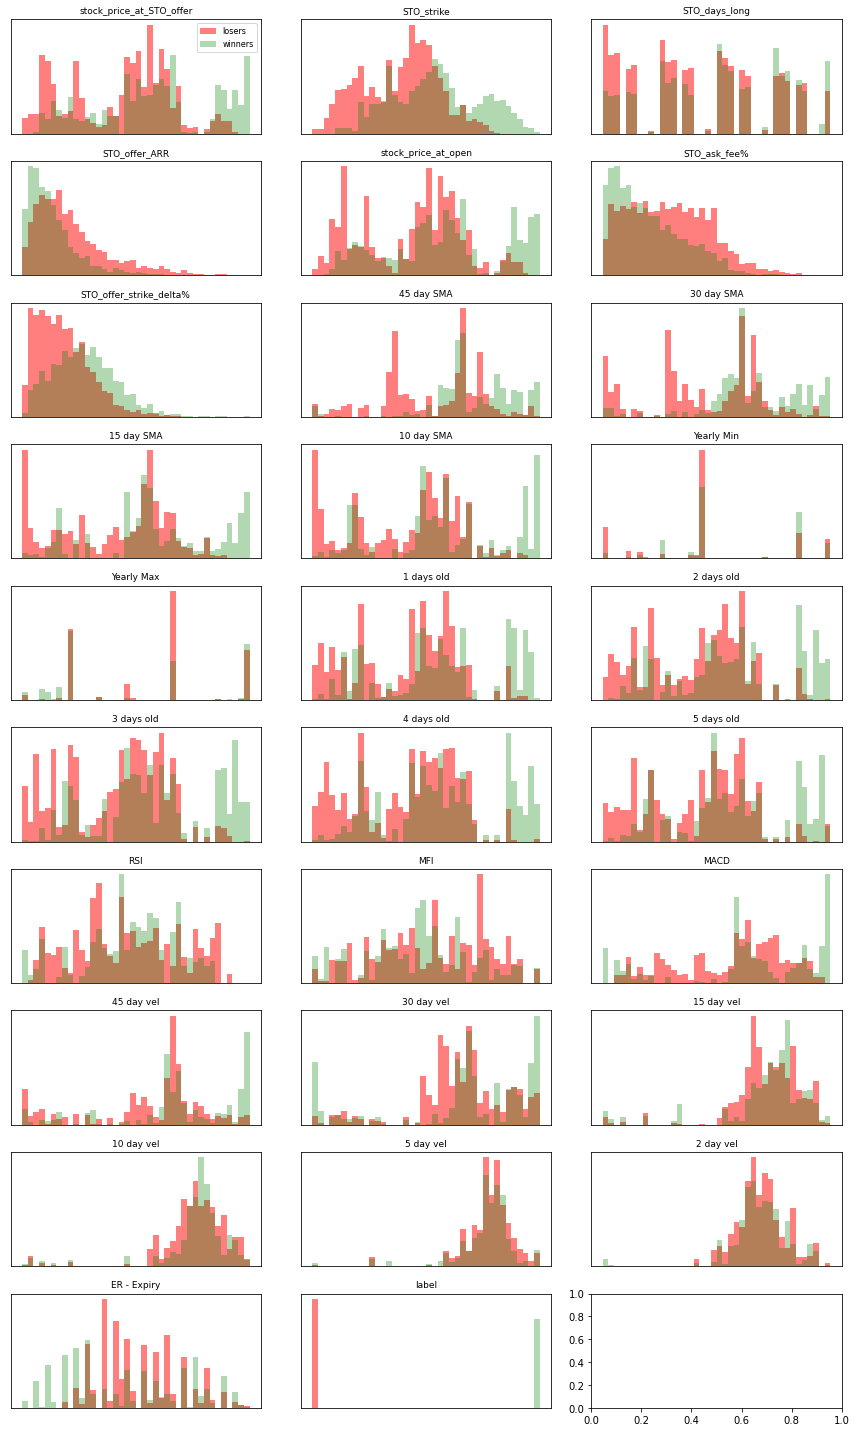

                      Specs        Score
8                30 day SMA  1354.967182
7                45 day SMA  1231.406356
1                STO_strike  1009.567483
9                15 day SMA   850.166718
10               10 day SMA   750.121984
15               3 days old   743.624494
16               4 days old   738.064573
6   STO_offer_strike_delta%   696.033340
17               5 days old   670.129106
14               2 days old   664.790360

RandomForest_d7  accuracy      =  0.9292035398230089
RandomForest_d7  avg. precison =  0.8947240990586023

RandomForest_d15  accuracy      =  0.9734513274336283
RandomForest_d15  avg. precison =  0.9554554736674512

RandomForest_d19  accuracy      =  0.9762168141592921
RandomForest_d19  avg. precison =  0.9611898668227394

KNNeighbors_2  accuracy      =  0.9585176991150443
KNNeighbors_2  avg. precison =  0.9372143672061466

AdaBoost  accuracy      =  0.9142699115044248
AdaBoost  avg. precison =  0.8632929007919389

GaussianNB  accuracy      =

In [11]:
#********************
#
# Visualizers - Histograms. 
# Show histograms of features grouped by label. See any separation visually for each feature.
#
#********************

Chart_Feature_Label_Separation(opt_sample)

#********************
#
# Feature Selection
# 1. Seaborn Heat Map - Add this from notebook.
# 2. SelectKBest - Add this from notebook.
# 3. RFE - Add from notebook.
# 4. 
#
#********************

X = X_train  #independent columns
y = y_train  #target column i.e price range
#apply SelectKBest class to extract top 10 best features
best_features = SelectKBest(score_func = f_classif, k=10)
fit = best_features.fit(X_train,y_train)

feature_scores = pd.DataFrame(fit.scores_)
feature_cols   = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([feature_cols,feature_scores],axis=1)
featureScores.columns = ['Specs','Score']  #name the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features



#********************
#
# GredSearchCV.  Tune yer hyperparameters.
#
#********************

# Find the highet hill to climb.

#********************
#
# Run several Learners. Get code from other notebook.
# 
#********************

y_train = np.ravel(y_train)
y_test  = np.ravel(y_test)
learner_stats = pd.DataFrame()
                 
run_ID = 'Initial'
learner_stats, y_preds = RunLearners(X_train, X_test, y_train, y_test, learner_stats, run_ID)
learner_stats.to_csv('learner_stats.csv')
y_preds.to_csv('learner_preds.csv')

predictions = opt_test.merge(y_preds, how = 'left', left_index = True, right_index = True)
predictions.to_csv('learner_predswlabels.csv')
#['KNNeighbors_3'] = y_preds['KNNeighbors_3']
#predictions['RandomForest_d15'] = y_preds['RandomForest_d15']

#********************
#
# Feature Selection / Reduction
#
# 1. Univariate ranking - SelectKBest
# 2. Correlation Ranking - Seaborn heat map
# 3. RFE
# 
#********************

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(k=10)
fit = bestfeatures.fit(X_train,y_train)
dfscores  = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #name the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

#********************
#
# PCA Analysis - PCA is Unsupervised Learning, so do not include the label in the data set. 
# Convert features df to ndarray - very tough. Use reshape and ravel.
# Note Standard Scaler does feature normalization.
#
# To visualize relative contributions of each feature, use:
#   1. heat map with seaborn.
#   2. heat map with relative contributions to each PCA.
#   3. overlapping histograms of each feature, grouped by label. Very Helpful.
#
#********************

opt_sample_nolabel = opt_sample.drop('label', axis = 'columns')
opt_sample_nda = opt_sample_nolabel.to_numpy()                    #create numpy data array with features only (drop labels)
#print(opt_sample_nda)
print(opt_sample_nda.shape)

scaler = StandardScaler()
scaler.fit(opt_sample_nda)
print('scaler.mean_ = ', scaler.mean_)
opt_sample_xform = scaler.transform(opt_sample_nda)

pca_n2 = PCA(n_components = 2)
PrincipalComponents_options = pca_n2.fit_transform(opt_sample_xform)  #Try with with plain opt_sample_nda

opt_PC_df = pd.DataFrame(data = PrincipalComponents_options, columns = ['principal component 1', 'principal component 2'])
opt_PC_df.tail() # for visual inspection
print('Explained variance per PC: {}'.format(pca_n2.explained_variance_)) 

print('pca components')
print(pca_n2.components_)
print()
PCA_factors = pd.DataFrame()
PCA_factors = pd.DataFrame(pca_n2.components_,columns=opt_sample_nolabel.columns,index = ['PC-1','PC-2'])
print(PCA_factors)

PCA_factors.to_csv('PCA_factors.csv')

print('+++++')
print('             Thats all, folks.')
print('+++++')

#********************
#
# Dimensionality Reduction - Identify and remove features with low information.
#
#********************
